# IMPORTS

In [200]:
import math
import warnings
import numpy  as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.core.display import HTML
from plotly.subplots import make_subplots

warnings.filterwarnings( 'ignore' )

##  Helper Functions

In [174]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
#    plt.rcParams['font.size'] = 24   
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('max_colwidth',200)
    pd.set_option('display.max_rows',2000)
    pd.set_option('display.max_columns',50)
    pd.set_option('display.float_format',lambda x: '{:,.2f}'.format(x) )   
    
def info(x):

    data = pd.DataFrame({'Columns' : x.columns,
                         'Dtypes' :  x.dtypes,
                         '# observ.': x.shape[0],
                         "# unique": x.nunique(),
                         '# nulls' : x.isna().sum(),
                         '% nulls' : x.isna().sum()/x.shape[0]*100
                        }).reset_index(drop=True)
    
    return print(data)    

In [171]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [4]:
df_cleaned_aldeia_realestate_raw = pd.read_csv( '../data/cleaned_aldeia_realestate.csv')

# DATA DESCRIPTION

In [5]:
df1=df_cleaned_aldeia_realestate_raw.copy()

## Data Information

In [175]:
info(df1)

           Columns   Dtypes  # observ.  # unique  # nulls  % nulls
0         page_seq    int64       1092        15        0     0.00
1        house_seq    int64       1092        36        0     0.00
2            title   object       1092       552        0     0.00
3              url   object       1092      1092        0     0.00
4          address   object       1092       341        0     0.00
5          area_m2  float64       1092       278        0     0.00
6         bedrooms  float64       1092         9        0     0.00
7        en_suites    int64       1092         9        0     0.00
8            price    int64       1092       198        0     0.00
9        bathrooms  float64       1092         9        0     0.00
10  parking_spaces    int64       1092        17        0     0.00
11            type   object       1092         1        0     0.00
12     street_name   object       1092       100      281    25.73
13   street_number  float64       1092       157      875    8

In [176]:
df1.sample(2)

,page_seq,house_seq,title,url,address,area_m2,bedrooms,en_suites,price,bathrooms,parking_spaces,type,street_name,street_number,city,condo_name
810,0,6,Casa de condominio com 4 Quartos a Venda 350m2,www.vivareal.com.br/imovel/casa-de-condominio-4-quartos-residencial-morada-dos-lagos-bairros-barueri-com-garagem-350m2-venda-RS1300000-id-2453702177/?__vt=plp:b,"Residencial Morada dos Lagos, Barueri - SP",350.00,4.00,4,1300000,4.00,2,House,NaN,nan,Barueri SP,Morada dos Lagos
561,1,8,Casa de condominio com 4 Quartos a Venda 440m2,www.vivareal.com.br/imovel/casa-de-condominio-4-quartos-morada-das-flores-aldeia-da-serra-bairros-santana-de-parnaiba-com-garagem-440m2-venda-RS1800000-id-2460653308/?__vt=plp:b,"Morada dos Pinheiros Aldeia da Serra , Santana de Parnaíba - SP",440.00,4.00,2,1800000,4.00,2,House,NaN,nan,Santana de Parnaíba SP,Morada dos Pinheiros


## Filter

In [177]:
#keeping only Houses from condominiums
df1 = df1[ (df1['type'] == 'House') & (df1['condo_name'] != 'Not Aldeia da Serra') & \
          (~ df1['condo_name'].isna()) & (df1['condo_name'] != 'Ingaí') & (df1['condo_name'] != 'Quintas do Ingaí')
         ]

## Fillout NA

In [9]:
# fill NaN with zeros
df1['en_suites'].fillna(0, inplace = True)
df1['parking_spaces'].fillna(0, inplace = True)

## Change Data Types

In [10]:
# change selected columns to integer
int_cols = ['en_suites', 'parking_spaces']
df1[int_cols] = df1[int_cols].astype(int)

# DESCRIPTIVE STATISTICS

In [167]:
# split numerical attributes from categorical in variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Numerical Atributes

In [178]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

# As we can see through the medians, a regular house in Aldeia da Serra is spacious (about 460 m2),
#has four bedrooms and bathrooms of those three are 3 en suites. There is space for four cars and 
#the regular price is about R$ 1,8 milhões (1 US$ = BLR 5.36 as of 07.06.2020). It's a suburban 
#area, with large houses for the whole family from A/B social classes.

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,page_seq,0.00,14.00,14.00,4.42,4.00,3.36,0.76,0.21
1,house_seq,0.00,35.00,35.00,17.33,17.50,10.37,0.01,-1.21
2,area_m2,20.00,"2,200.00","2,180.00",458.03,400.00,237.54,3.16,14.54
3,bedrooms,1.00,10.00,9.00,3.87,4.00,0.81,1.34,7.84
4,en_suites,0.00,8.00,8.00,3.10,3.00,1.27,-0.01,-0.00
5,price,"585,000.00","15,000,000.00","14,415,000.00","2,352,439.41","1,800,000.00","1,605,420.42",3.39,17.67
6,bathrooms,1.00,10.00,9.00,3.87,4.00,0.81,1.34,7.84
7,parking_spaces,0.00,20.00,20.00,4.37,4.00,2.19,1.72,5.32
8,street_number,nan,nan,"6,720.00",728.41,nan,878.19,3.24,18.19


In [179]:
px.histogram(df1, 
             x = 'area_m2' ,
             title = 'House Prices Histogram and Boxplot',
             labels = {'price': 'house price'},
             marginal = 'box'
            )
# The distribution of the area is skewed to the right, with several outliers with size greater than 762 squared meters.
# There are to outlier to the left side with less than 100 squared meters, at leat one seem to be typo.

### Categorical Atributes

In [181]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

# There are houses from 2 cities (Santana de Parnaiba and Barueri), 101 street names and 8 different condominuns.
# There should be one more city and at least 1 more condominim, signalizing that there is room for categorization
# improvement, beyound the website information.

title           552
url            1092
address         341
type              1
street_name     101
city              2
condo_name        8
dtype: int64

In [15]:
fig = px.box(data_frame=df1,
             x='price',
             y='condo_name',
             labels={ 'price' : 'house price',
                      'condo_name': 'condominium'
                    },
             title='House price boxplot by condominium'
            )
fig.show()

# Median prices varies a lot by condomium and some have lots of high price outlier houses, 
# especially Morada dos Lagos e dos Pássaros

# 2.0.  FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.4. Feature Engineering

In [16]:
# let's calculate price per squared meter
df2['price_m2'] = df2['price']/df2['area_m2']

In [182]:
# lets discretize area by categorizing it in 7 items
# this categorization may not be intuitive and needing to be customized also taking into consideration
# the number of bedrooms, for instance. For the sake of simplicity and agility to show a minimum viable product,
# we will follow like this and evaluate a customized version in future cicles

df2['size'] = pd.qcut(df2['area_m2'], 7, labels=['01 Cozy', '02 Small', '03 Medium', '04 Large', '05 Super large', '06 gigantic', '07 Pharaonic'])

In [25]:
df2['size'].value_counts()

06 gigantic       162
02 Small          162
05 Super large    159
01 Cozy           156
04 Large          155
03 Medium         151
07 Pharaonic      147
Name: size, dtype: int64

In [31]:
#df2[df2['size'] == '07 Pharaonic']

## Hipothesis

**1.** Morada dos Lagos, Pássaros e Estrelas have highest prices per square meter (m2).

**2.** Barueri-SP city prices are higher than Santana de Parnaíba-SP.

**3.** Houses with 4 bedrooms have higher prices per m2.

**4.** Houses with suites have higher prices per m2 on average.

**4.** Morada dos Lagos have more large houses.

# FILTERING

In [75]:
df3 = df2.copy()

## Filtragem das Linhas


In [91]:
# Analysis showed some outliers with less than 100 square meters or price lower than R$600 K
# Let's get rid of them
df3 = df3[ (df3['area_m2']> 100) & (df3['price']> 600000) ]

In [82]:
# Two houses has gone
df3.shape

(1090, 13)

## Selecao das Colunas

In [183]:
# Let's drop some auxiliary and worthless columns to the analysis and modeling
df3.drop(['page_seq', 'house_seq', 'title', 'address', 'street_number'], axis =1, inplace=True)

KeyError: "['page_seq' 'house_seq' 'title' 'address' 'street_number'] not found in axis"

# EXPLORATORY DATA ANALYSIS

In [84]:
df4 = df3.copy()

## Analise Univariada

### Response Variable

In [193]:
px.histogram(df4, 
             x = 'price' ,
             title = 'House Prices Histogram and Boxplot',
             labels = {'price': 'house price (BLR) f/x: 1 USD = 5.36 BRL'},
             marginal = 'box'
            )
# same skewesness observed in the area attribute
# the are two huge and high priced houses
# by analyzing the high priced houses, we could find that there are 'duplicated' records for them
# same house with different codes, sometimes with different prices

In [194]:
px.histogram(df4, 
             x = 'price_m2' ,
             title = 'House Prices Histogram and Boxplot',
             labels = {'price_m2': 'house price (BLR) per square meter house f/x: 1 USD = 5.36 BRL'},
             marginal = 'box'
            )
# there are very high prices per squared meter
# aditional info should be usefull to understand it, such as, when the house was built and reformulated
# if it's to be sold with mobilia

### Numerical Variable

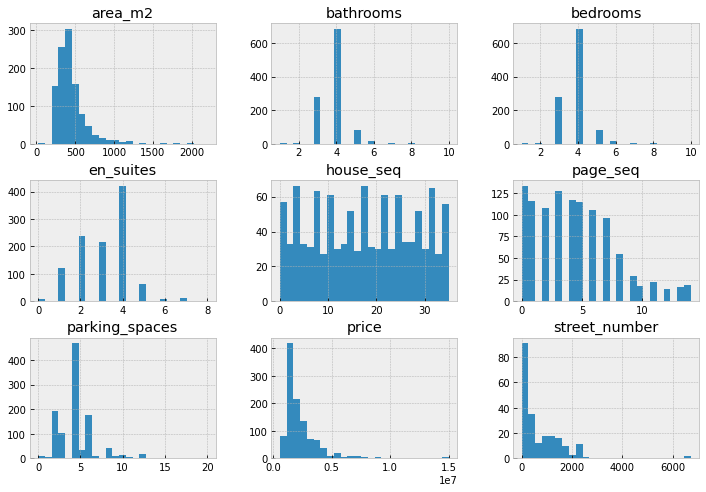

In [195]:
num_attributes.hist( bins=25 );

###  Categorical Variable

In [196]:
#condo_name
#city
#size



## 4.2. Analise Bivariada

**1.** Morada dos Lagos, Pássaros e Estrelas have highest prices per square meter (m2).

**2.** Barueri-SP city prices are higher than Santana de Parnaíba-SP.

**3.** Houses with 4 bedrooms have higher prices per m2.

**4.** Houses with suites have higher prices per m2 on average.

**4.** Morada dos Lagos have more large houses.

### **H1.**Morada dos Lagos, Pássaros e Estrelas have highest prices per square meter (m2).
**** .

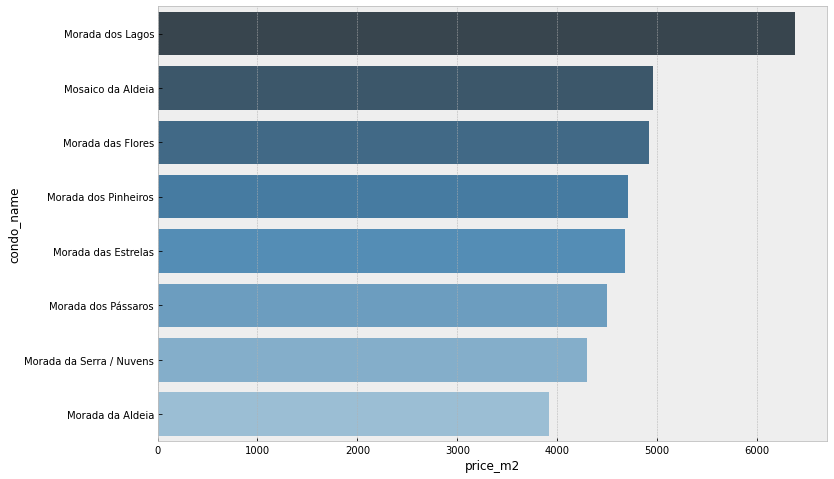

In [210]:
aux1 = df4.groupby('condo_name')['price_m2'].mean().sort_values(ascending= False).reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

sns.barplot(data = aux1, y='condo_name', x='price_m2', palette="Blues_d");

### **H2.** Barueri-SP city prices are higher than Santana de Parnaíba-SP.
**** 

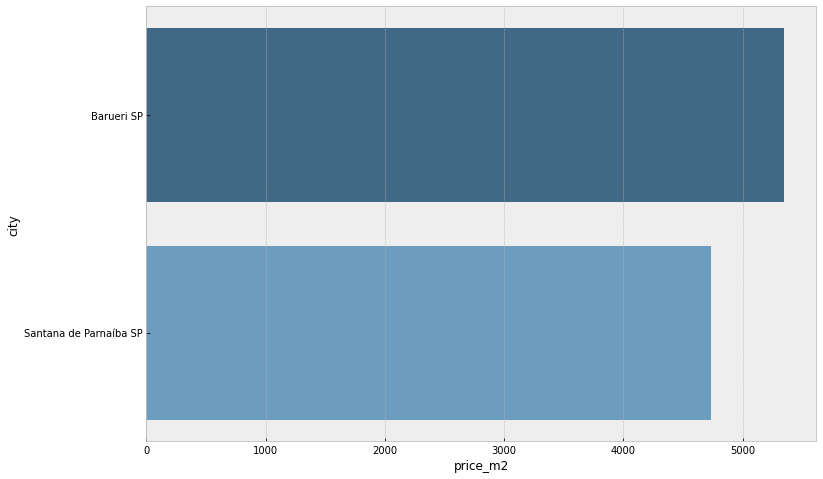

In [212]:
aux1 = df4.groupby('city')['price_m2'].mean().sort_values(ascending = False).reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)


sns.barplot(data = aux1, y='city', x='price_m2', palette="Blues_d");


### **H3.** Houses with 4 bedrooms have higher prices per m2.
**** 

In [216]:
aux1 = df4.groupby('bedrooms')['price_m2'].mean().sort_values().reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

px.bar(data_frame = aux1,
        x='bedrooms',
        y='price_m2',
        color='bedrooms',
        text='price_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'condo_name': 'Condominium'           
               }
        )


### **H4.** Houses with suites have higher prices per m2 on average.
**** 

In [165]:
aux1 = df4.groupby('en_suites')['price_m2'].mean().sort_values().reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

px.bar(data_frame = aux1,
        x='en_suites',
        y='price_m2',
        color='en_suites',
        text='price_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'en_suites': '# of Suites'           
               }
        )


### **H5.** Morada dos Lagos have more large houses.
**** 

In [223]:
aux1 = df4.groupby('condo_name')['size'].count().sort_values().reset_index()

aux1
# px.bar(data_frame = aux1,
#         x='condo_name',
#         y='area_m2',
#         color='condo_name',
#         text='area_m2',
#         title = 'Average price per m2',
#         labels={'price_m2':'Price avg per m2',
#                 'condo_name': 'Condominium'           
#                }
#         )

,condo_name,size
0,Mosaico da Aldeia,2
1,Morada da Aldeia,13
2,Morada da Serra / Nuvens,30
3,Morada das Estrelas,34
4,Morada das Flores,144
5,Morada dos Pinheiros,261
6,Morada dos Lagos,292
7,Morada dos Pássaros,314


In [ ]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )